# 題目
There are two datasets, crx.csv and data.csv, please use them to complete the requirements for this assignment below:

1. The labels column in crx and data are "label" and " Diagnosis"

2. Please implement the Linear Classifier from scratch with the update rule in the slide. It means you cannot adopt any existing package like sklearn in this assignment. 

3. When the $J=WX+b$ could be represented as the matrix form for the linear classifier, please find the solution by solving this equation using least-squared manner. Also, please implement it and make a comparison between this method and the previous one implemented in 2.

4. Please implement the voted perception and make the performance comparison between methods.

5. With minimizing the $||w||^2$, it should drive the marginal to be maximized as well. Please implement the linear classifier with the minimum $||w||^2$ property and verify whether the margin of this version is larger than that of the conventional linear classifier or not. 

6. Based on 5, please add the slack variable term in the linear classifier and find the most effective weighting value C.

7. Use any existing SVM package (libSVM, sklearn, or Matlab SVM), please make a performance comparison between the built-in SVM and your implementation.



All the source code should be uploaded to GitHhub with public access. The performance comparison should be organized into a formal report with the standard template indicated in Moodle.

In [ ]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from perceptron import VotePerceptron
plt.style.use("ggplot")

# percrptron原理為
$predict_y = w_2x_1 + w_1x_2 + ... w_nx_n = \sum_{i=1}^{n}X_iW_i$ <BR>

若$predict_y != y$<BR>

則修正$W_n = W_{n-1} + XY$

# 匯入CSV檔案

In [6]:
dataset1 = pd.read_csv("data/crx.csv")
dataset2 = pd.read_csv("data/data.csv", index_col=0)

# dataset1
共有690筆資料，我們取80%資料作為train data，20%作為test data<BR>
發現dataset1中有較多類別資料，先篩選類別資料進行one-hot encoding再合併

In [7]:
# 查看類別資料, 其中att2、att14應為非類別資料，稍後作處理
dataset1.describe(include=["O"])

,att1,att2,att4,att5,att6,att7,att9,att10,att12,att13,att14,label
count,690,690,690,690,690,690,690,690,690,690,690,690
unique,3,350,4,4,15,10,2,2,2,3,171,2
top,b,?,u,g,c,v,t,f,f,g,0,-
freq,468,12,519,519,137,399,361,395,374,625,132,383


In [217]:
# 查看非類別資料
dataset1.describe(exclude=["O"])

,att3,att8,att11,att15
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


In [8]:
# 將x1(features), y1(labels)分開
x1 = dataset1.iloc[:, dataset1.columns != "label"]
y1 = dataset1.label.replace({"+": 1, "-": -1}).values

# 將att2、att14轉換成非類別資料
x1.att2 = x1.att2.replace("?", 0).astype(np.float64)
x1.att14 = x1.att14.replace("?", 0).astype(np.float64)

# 將x1
x1_categorical = x1.select_dtypes(include=["O"])
x1_non_categorical = x1.select_dtypes(exclude=["O"])

/tmp/ipykernel_8340/521712616.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1.att2 = x1.att2.replace("?", 0).astype(np.float64)
/tmp/ipykernel_8340/521712616.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1.att14 = x1.att14.replace("?", 0).astype(np.float64)


In [9]:
# 使用sklearn進行one-hot encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(x1_categorical)
one_hot_categorical_arr = enc.transform(x1_categorical).toarray()

# 確定one-hot結果與預期相符
assert x1_categorical.describe().loc["unique"].sum() == enc.transform(x1_categorical).toarray().shape[-1]

# 合併類別、非類別資料
non_categorical_arr = x1_non_categorical.values
x1 = np.hstack((one_hot_categorical_arr, non_categorical_arr))

[0.99888207 0.00110991]


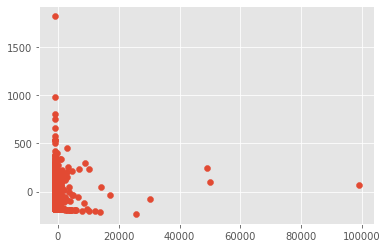

In [231]:
# 先用PCA看看資料分布，由於dataset1有大量類別資料此處效果並不好
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x1)
print(pca.explained_variance_ratio_)

pc1, pc2 = pca.transform(x1)[:, 0], pca.transform(x1)[:, 1]
plt.scatter(pc1, pc2)

In [10]:
# 使用sklearn來分割訓練集與測試集
from sklearn.model_selection import train_test_split

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, train_size=0.8)

In [11]:
# 使用sklearn內建perceptron測試
from sklearn import linear_model

sklearn_perceptron = linear_model.Perceptron()
sklearn_perceptron.fit(x1_train, y1_train)
sklearn_perceptron.score(x1_train, y1_train), sklearn_perceptron.score(x1_test, y1_test)

(0.6268115942028986, 0.7101449275362319)

In [12]:
# 使用sklearn內建SVM測試
from sklearn import svm

svc = svm.SVC()
svc.fit(x1_train, y1_train)
svc.score(x1_train, y1_train), svc.score(x1_test, y1_test)

(0.6503623188405797, 0.6666666666666666)

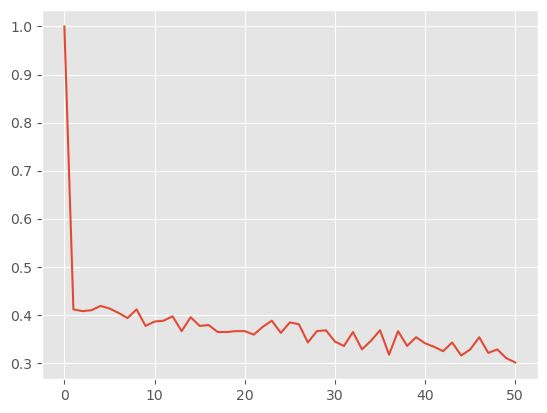

In [14]:
# 使用自定義vote perceptron
perceptron1 = VotePerceptron()
perceptron1.import_data(x1_train, y1_train, x1_test, y1_test)
perceptron1.fit(50) # 此處因需記錄權重較多，僅訓練50epoch
perceptron1.error_plot()

In [15]:
# 僅用最後一次作預測準確度0.81>0.5，為可接受模型，且結果>SVC>sklearn_perceptron
y_predict = perceptron1.predict(perceptron1.x_test)
accuracy = 1 - perceptron1.error_rate(y_predict, perceptron1.y_test)
accuracy

0.8115942028985508

In [256]:
# vote perceptron準確度0.63>0.5，為可接受模型，SVC>結果>sklearn_perceptron
y_predict = perceptron1.vote_predict(perceptron1.x_test)
accuracy = 1 - perceptron1.error_rate(y_predict, perceptron1.y_test)
accuracy

0.6376811594202898

# Dataset2
dataset2為連續資料，不用進行前處理

In [232]:
# 使用sklearn來分割訓練集與測試集

x2 = dataset2.loc[:, dataset2.columns != "Diagnosis"].values
y2 = dataset2.Diagnosis.replace({"M": 1, "B": -1}).values
 
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, train_size=0.8)

[0.98204467 0.01617649]


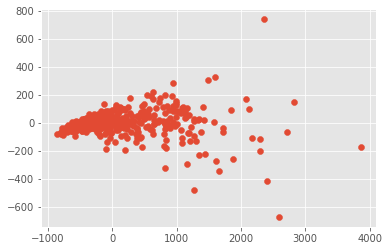

In [233]:
#利用PCA降維資料，稍微看一下資料分布
pca = PCA(n_components=2)
pca.fit(x2)
print(pca.explained_variance_ratio_)

pc1, pc2 = pca.transform(x2)[:, 0], pca.transform(x2)[:, 1]
plt.scatter(pc1, pc2)

# 先使用sklearn驗證輸入輸出，並先行比較SVM與perceptron

In [240]:
# 使用sklearn內建perceptron測試
perceptron = linear_model.Perceptron()
perceptron.fit(x2_train, y2_train)
perceptron.score(x2_train, y2_train), perceptron.score(x2_test, y2_test)

(0.9186813186813186, 0.9035087719298246)

In [241]:
# 使用sklearn內建SVM測試
svc = svm.SVC()
svc.fit(x2_train, y2_train)
svc.score(x2_train, y2_train), svc.score(x2_test, y2_test)

(0.9098901098901099, 0.8947368421052632)

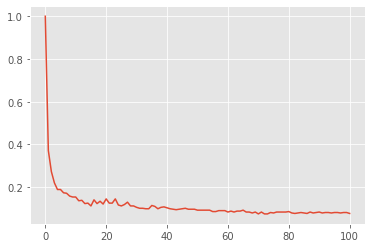

In [257]:
# 使用自定義vote perceptron
perceptron2 = VotePerceptron()
perceptron2.import_data(x2_train, y2_train, x2_test, y2_test)
perceptron2.fit(max_epoch=100)
perceptron2.error_plot()

In [258]:
# 可以看到此處測試集上準確度0.89>0.5，為可接受模型，sklearn_perceptron>SVM>vote perceptron
y_predict = perceptron2.vote_predict(perceptron2.x_test)
accuracy = 1 - perceptron2.error_rate(y_predict, perceptron2.y_test)
accuracy

0.8859649122807017

In [259]:
# 僅用最後一次權重預測，為可接受模型，sklearn_perceptron>perceptron>SVM
y_predict = perceptron2.predict(perceptron2.x_test)
accuracy = 1 - perceptron2.error_rate(y_predict, perceptron2.y_test)
accuracy

0.8947368421052632